In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

In [2]:
class DeepfakeClassifier(nn.Module):
    def __init__(self, type='efficientnet-b0', decision_layer = "fc"):
        super(DeepfakeClassifier, self).__init__()
        self.model = EfficientNet.from_pretrained(type)
        self.fc = nn.Linear(self.model._fc.in_features, 1)
        self.model._fc = self.fc
    def forward(self, x):
        return torch.sigmoid(self.model(x))

In [3]:
from timm import create_model

class DeepfakeClassifier_timm(nn.Module):
    def __init__(self, type='vit_base_patch16_224'):
        super(DeepfakeClassifier_timm, self).__init__()
        self.model = create_model(type, pretrained=True, num_classes=1)
    def forward(self, x):
        return torch.sigmoid(self.model(x))

c:\Users\Raulg\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
class DeepfakeClassifier_convnext(nn.Module):
    def __init__(self, type='convnext_tiny'):
        super(DeepfakeClassifier_convnext, self).__init__()
        self.model = create_model(type, pretrained=True, num_classes=0)  # Set num_classes=0 to remove the head
        self.fc = nn.Linear(self.model.num_features, 1)  # Add our own classifier head
        
    def forward(self, x):
        x = self.model.forward_features(x)  # Get features before the head
        x = self.model.forward_head(x, pre_logits=True)  # Get pre-logits
        x = self.fc(x)
        return torch.sigmoid(x)

In [5]:
def setup_data(input_size = (224, 224), data_dir = 'data'):

    transform = transforms.Compose([  
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = datasets.ImageFolder(data_dir, transform=transform)

    print("Dataset classes", dataset.classes)

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size

    print("Train size: ", train_size)
    print("Validation size: ", val_size)
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

    print("Class to index mapping: ", dataset.class_to_idx)

    return train_loader, val_loader, transform, dataset

In [6]:
class GradCAM:
    def __init__(self, model, target_layer):

        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()
    def _register_hooks(self):

        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]
        
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)
    
    def generate(self, input_image, target_class=None):

        self.model.zero_grad()

        output = self.model(input_image)
        if target_class is None:
            target_class = torch.argmax(output)
        
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        # print("One_hot shape: ", one_hot.shape)
        # print(one_hot)
        one_hot[0 , target_class] = 1
        output.backward(gradient=one_hot)
        
        gradients = self.gradients.detach().cpu().numpy()[0]
        activations = self.activations.detach().cpu().numpy()[0]
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.sum(weights[:, np.newaxis, np.newaxis] * activations, axis=0)

        cam = np.maximum(cam, 0)
        cam = cam/ cam.max()
        return cam

In [7]:
def visualize_cam_on_image(model, image, target_layer, target_class=None):

    grad_cam = GradCAM(model, target_layer)
    heatmap = grad_cam.generate(image, target_class)

    img = image.squeeze().permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())

    heatmap_reized = F.interpolate(
        torch.tensor(heatmap).unsqueeze(0).unsqueeze(0),
        size=(img.shape[0], img.shape[1]),
        mode='bilinear',
        align_corners=False
    ).squeeze().cpu().numpy()

    overlay = plt.cm.jet(heatmap_reized)[..., :3] *0.4 + img * 0.6

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    axs[1].imshow(heatmap_reized, cmap = 'jet')
    axs[1].set_title('Heatmap')
    axs[1].axis('off')
    axs[2].imshow(overlay)
    axs[2].set_title('Overlay')
    axs[2].axis('off') 
    plt.title(f"Target class: {target_class}")
    plt.show()

In [8]:
def plot_tsne(model, train_loader, val_loader):
    features = []
    labels = []
    for dataloader in [train_loader, val_loader]:
        for inputs, targets in dataloader:
            with torch.no_grad():
                # Handle different model architectures
                if hasattr(model.model, 'extract_features'):
                    # EfficientNet
                    output = model.model.extract_features(inputs)
                elif hasattr(model.model, 'forward_features'):
                    # ConvNeXt and ViT
                    output = model.model.forward_features(inputs)
                    if isinstance(output, tuple):
                        output = output[0]  # Some models return tuple
                else:
                    raise AttributeError(f"Model {type(model.model).__name__} doesn't support feature extraction")
                
                # Use reshape instead of view to handle non-contiguous tensors
                output_vector = output.reshape(output.size(0), -1)
                features.append(output_vector.detach().cpu().numpy())
                labels.append(targets.detach().cpu().numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    print(features.shape, labels.shape)
    tsne = TSNE(n_components=2, random_state=42)
    reduced_features = tsne.fit_transform(features)

    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis')
    plt.colorbar()
    plt.show()

{'feature_extraction': 'efficientnet-b0', 'decision_layer': 'fc', 'input_size': (224, 224), 'data_dir': 'data'}
Loaded pretrained weights for efficientnet-b0
Train loss: 0.00042657821511966177
Validation loss: 0.005773959190119058
Validation accuracy: 0.9525


c:\Users\Raulg\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


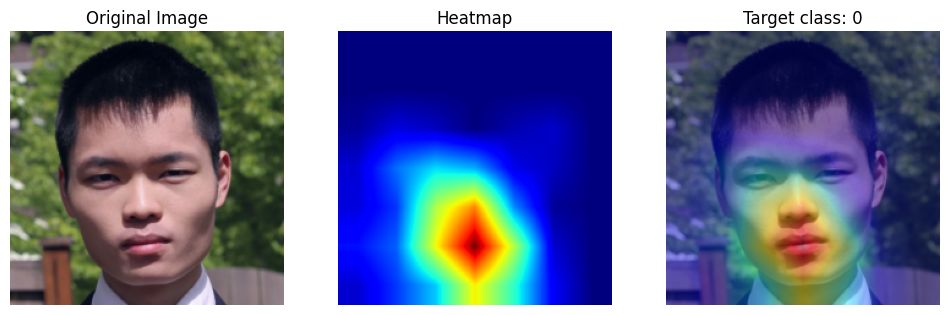

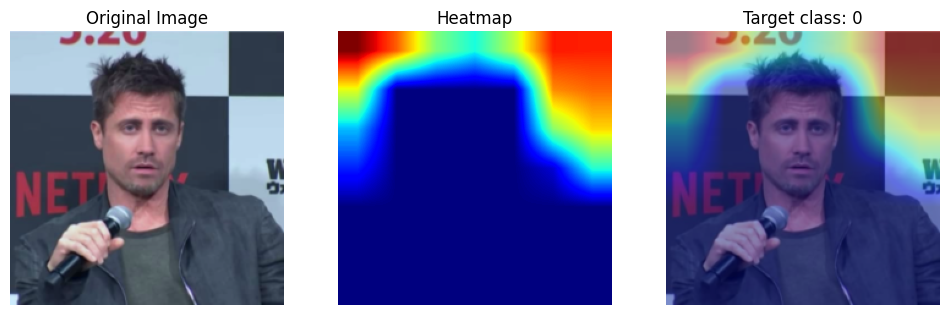

Dataset classes ['fake', 'real']
Train size:  1600
Validation size:  400
Class to index mapping:  {'fake': 0, 'real': 1}
(2000, 62720) (2000,)


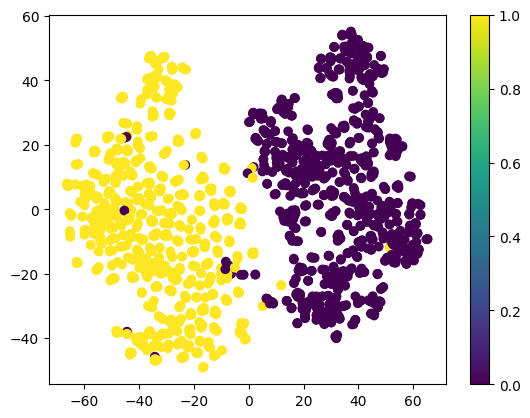

{'feature_extraction': 'efficientnet-b1', 'decision_layer': 'fc', 'input_size': (240, 240), 'data_dir': 'data'}
Loaded pretrained weights for efficientnet-b1
Train loss: 0.0020455354976002126
Validation loss: 0.004000976698007435
Validation accuracy: 0.955


c:\Users\Raulg\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


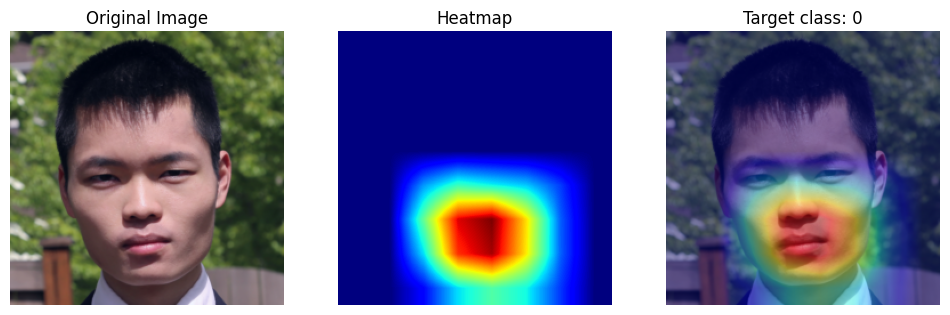

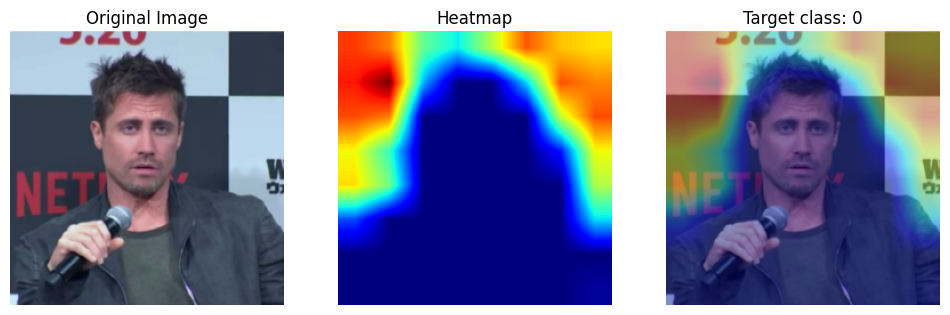

Dataset classes ['fake', 'real']
Train size:  1600
Validation size:  400
Class to index mapping:  {'fake': 0, 'real': 1}
(2000, 81920) (2000,)


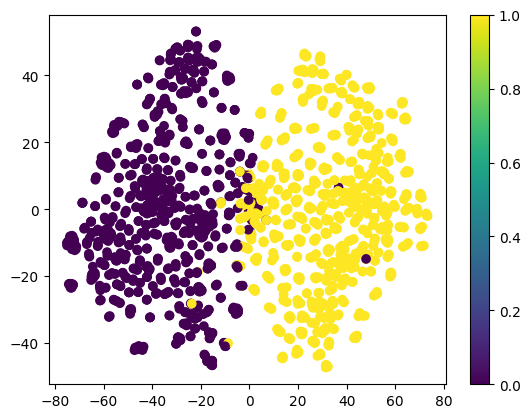

{'feature_extraction': 'efficientnet-b2', 'decision_layer': 'fc', 'input_size': (260, 260), 'data_dir': 'data'}
Loaded pretrained weights for efficientnet-b2
Train loss: 0.0002521481806252268
Validation loss: 0.003510441282414831
Validation accuracy: 0.975


c:\Users\Raulg\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


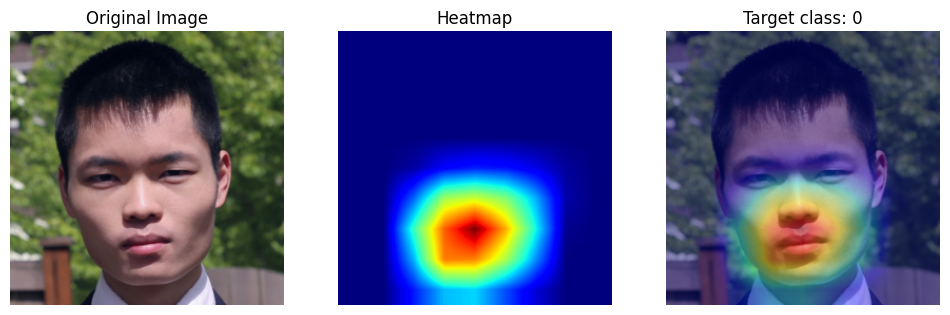

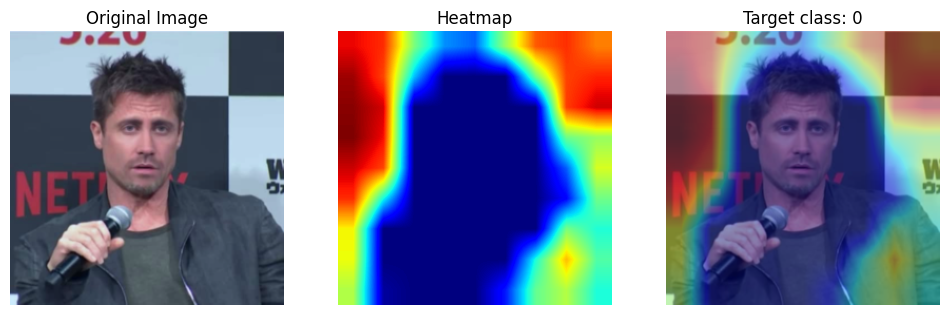

Dataset classes ['fake', 'real']
Train size:  1600
Validation size:  400
Class to index mapping:  {'fake': 0, 'real': 1}


KeyboardInterrupt: 

In [9]:
# Inputs sizes all dervied from the efficientNet-pytorch library, each model has a different input size
model_configs = {
    "b0" : {
        "feature_extraction": "efficientnet-b0",
        "decision_layer": "fc",
        "input_size": (224, 224),
        "data_dir": "data"
    },
    "b1" : {
        "feature_extraction": "efficientnet-b1",
        "decision_layer": "fc",
        "input_size": (240, 240),
        "data_dir": "data"
    },
    "b2" : {
        "feature_extraction": "efficientnet-b2",
        "decision_layer": "fc",
        "input_size": (260, 260),
        "data_dir": "data"
    },
    "b3" : {
        "feature_extraction": "efficientnet-b3",
        "decision_layer": "fc",
        "input_size": (300, 300),
        "data_dir": "data"
    },
}


def visualize_model(model_configs, model_name="b0", images=None):
    print(model_configs[model_name])
    model = DeepfakeClassifier(model_configs[model_name]["feature_extraction"], model_configs[model_name]["decision_layer"])
    model_path = "saved_models//" + model_configs[model_name]["feature_extraction"] + " " + model_configs[model_name]["decision_layer"] + ".pth"
    saved = torch.load(model_path,weights_only=True)
    model.load_state_dict(saved['model_state_dict'])

    print("Train loss:", saved['train_loss'])
    print("Validation loss:", saved['val_loss'])
    print("Validation accuracy:", saved['val_accuracy'])


    for image_path in images:
        image = Image.open(image_path).convert('RGB')

        transform = transforms.Compose([
        transforms.Resize(model_configs[model_name]["input_size"]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
        model.eval()
        input_tensor = transform(image).unsqueeze(0)
        output = model(input_tensor)
        # print(output)
        predicted_class = torch.argmax(output).item()
        target_layer = model.model._blocks[-1]
        visualize_cam_on_image(model, input_tensor, target_layer, target_class=predicted_class)
    
    data_dir = model_configs[model_name]["data_dir"]
    train_loader, val_loader, transform, dataset = setup_data(model_configs[model_name]["input_size"], data_dir)
    plot_tsne(model, train_loader, val_loader)

images = [r"C:\Users\Raulg\Desktop\ECE661_Final_Project\661_DeepfakeProject\stargan-v2-master\data\celeba_hq\train\amale\000002.jpg",
          r"C:\Users\Raulg\Desktop\ECE661_Final_Project\661_DeepfakeProject\Classifier\data\fake\id1_id2_0002_00120.png",]
models = ["b0", "b1", "b2", "b3"]
for model_name in models:
    visualize_model(model_configs, model_name, images)